# Radial basis function network 

From a set of points $P:=\{p_i\}_{i \in I}$ and values $F:=\{f_i\}_{i \in I}$, an RBF network is an approximation $\tilde{f}(x)$,  

$$\tilde{f}(x) = \sum_{j \in C} w_j \phi(x - c_j)$$

The $\{w_j\}_{j \in C}$ are the network's weights, and $C:=\{c_j\}_{j \in C}$ are the RBF center points (centers). The weights $w_j$ are found by minimizing 

$$MSE = \sum_{i \in I} (f_i - \tilde{f}(p_i))^2$$

where $p_i \in P$, $f_i \in F$. Note tha $c_j \ne p_i$ for any $i,j$ which translates into choosing centers from available points and function values first, then making sure that those centers and their values are not in the training data set. 

Epoch: 0/10000, Loss: 0.12737736105918884
Epoch: 1000/10000, Loss: 0.011023594066500664
Epoch: 2000/10000, Loss: 0.00903868768364191
Epoch: 3000/10000, Loss: 0.007673115935176611
Epoch: 4000/10000, Loss: 0.006710281129926443
Epoch: 5000/10000, Loss: 0.00599082512781024
Epoch: 6000/10000, Loss: 0.005390820559114218
Epoch: 7000/10000, Loss: 0.0049176593311131
Epoch: 8000/10000, Loss: 0.00453012902289629
Epoch: 9000/10000, Loss: 0.004211466759443283


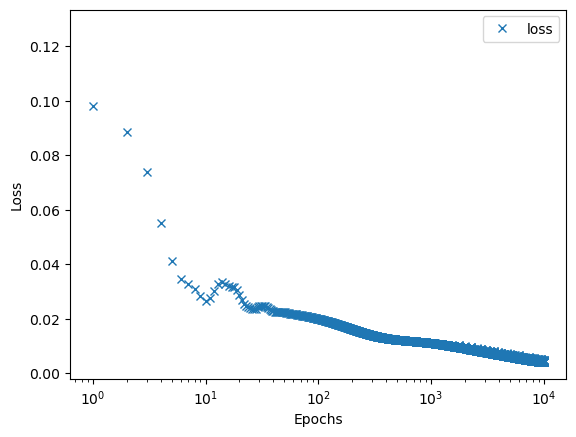

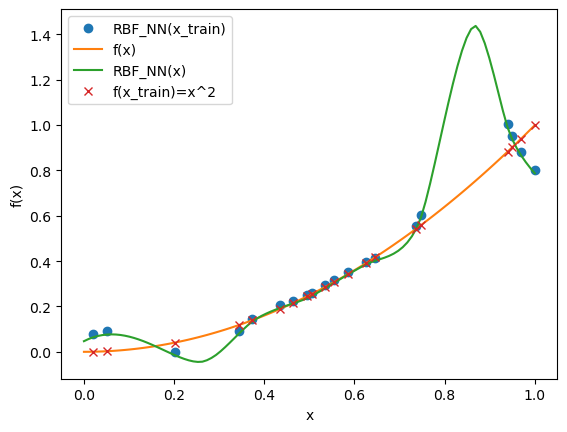

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# TODO(TM): extend with a linear model
class TPS_RBF(torch.nn.Module):
    def __init__(self, centers, bending_energy, epsilon=1e-09):
        super(TPS_RBF, self).__init__()
        self.centers = centers
        # Add a last dimension (1) for broadcasting.
        if (self.centers.shape[-1] != 1):
            self.centers.unsqueeze_(len(self.centers.shape))
        n_weights = len(centers) + 1
        self.weights = torch.randn(n_weights)
        self.weights = torch.abs(torch.randn(n_weights))
        self.weights = self.weights / self.weights.sum()
        # Add a last dimension (1) for broadcasting.
        self.weights.unsqueeze_(len(self.weights.shape))
        self.weights = torch.nn.Parameter(self.weights)
        self.bending_energy = bending_energy
        self.epsilon = epsilon
        
    def forward(self, points):
        # For every point in points compute the dist vector to all centers c.
        assert points.shape[-1]==1, "Last dimension must be 1 for broadcasting."
        deltas = points[:, np.newaxis] - self.centers
        # Compute the radius vector as an Euclidean norm of individual dist vectors.
        radii = torch.norm(deltas, p=2, dim=2)
        # Compute the RBF vector. 
        phis = radii**2 * torch.log(radii + self.epsilon)
        # Add dimension for broadcasting.
        phis = phis.unsqueeze(len(phis.shape))
        # Compute the weighted sum of the RBF vector as a function value. 
        # Self.weights[0] is the bias of the RBF network.
        values = self.weights[0] + torch.tensordot(phis, self.weights[1:], dims=2)  
        # TODO(TM): Apply the Thin Plate Spline RBF bending penalty.
        #bending_penalty = torch.sum(torch.pow(self.weights[1:], 2)) * self.bending_energy
        return values # + bending_penalty

# Define the true function that we want to approximate
def true_func(x):
    return x**2

# All points and values
points_vis = torch.linspace(0,1,100)
# Append one dimension for broadcasting. 
if (points_vis.shape[-1] != 1):
    points_vis = points_vis.unsqueeze(len(points_vis.shape))

values_vis = true_func(points_vis)

# Training points and values
n_training_points = 20 
train_indices = torch.randperm(len(points_vis))[:n_training_points]
points_train = points_vis[train_indices]
values_train = true_func(points_train)

# RBF center points 
# Select RBF centers that are different from training points.
all_indices = set(torch.arange(len(points_vis)))
center_candidates = all_indices - set(train_indices)
center_candidates = torch.tensor(list(center_candidates))
n_centers = 10
center_selection = torch.randperm(len(center_candidates))[:n_centers]
center_indices = center_candidates[center_selection]
# Test that RBF centers do not coincide with training points.
assert(len(set(train_indices).intersection(set(center_indices))) == 0)
centers = points_vis[center_indices]
center_values = values_vis[center_indices]

bending_energy = torch.tensor([0.01], requires_grad=True)
model = TPS_RBF(centers, bending_energy)

# Define the optimizer and the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_values = []

# Train the model
num_epochs = 10000
for epoch in range(num_epochs):
    f_pred = model(points_train)
    f_pred = f_pred.unsqueeze(len(f_pred.shape))
    loss = criterion(f_pred, values_train)
    loss_values.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    if epoch % 1000 == 0:
        print("Epoch: {}/{}, Loss: {}".format(epoch, num_epochs, loss.item()))

# Plot the loss function
plt.plot(np.arange(num_epochs), loss_values, 'x', label='loss')
plt.semilogx()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the results
rbf_vis = model(points_vis)
plt.plot(points_train, f_pred.detach().numpy(), 'o', label="RBF_NN(x_train)")
plt.plot(points_vis, values_vis, label="f(x)")
plt.plot(points_vis, rbf_vis.detach().numpy(), label="RBF_NN(x)")
plt.plot(points_train, values_train, "x", label="f(x_train)=x^2")
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend()